In [41]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
import ast
%matplotlib inline

In [42]:
train_info = pd.read_csv('information_train.csv',delimiter='\t')
train= pd.read_csv('train.csv')

In [43]:
test_info = pd.read_csv('information_test.csv',delimiter='\t')
test= pd.read_csv('test.csv')

In [44]:
train.ref_list=train.ref_list.apply(lambda x: ast.literal_eval(x))

In [45]:
all_info = pd.concat((train_info,test_info)).reset_index(drop=True)

In [46]:
all_info['author_list'] = all_info.author_str.apply(lambda x: x.split(',') if x==x else np.nan)

all_info['pub_date'] = pd.to_datetime(all_info.pub_date)

In [47]:
all_info['author_list']=all_info['author_list'].apply(lambda x: [y.strip(' ').replace('.','') for y in x] if x==x else np.nan)

In [48]:
all_info['author_list_last_names'] = all_info['author_list'].apply(
    lambda x: [y.split(' ')[-1] for y in x] if x==x else np.nan)

In [50]:
train.ref_list=train.ref_list.apply(lambda x: [int(y) for y in x])

In [51]:
train_df=train.set_index('pmid').ref_list.apply(pd.Series).stack().reset_index(
    level=-1, drop=True).astype(int).reset_index().rename(columns={0:'out_pmid'})

In [52]:
train_df['is_cited']=1

In [53]:
train2=train.merge(all_info[['pmid','set']],how='left',on='pmid').merge(
    all_info[['pmid','set']],on='set',how='left')[
    ['pmid_x','pmid_y']].rename(columns={'pmid_x':'pmid','pmid_y':'out_pmid'})

In [54]:
train2['is_cited']=0

In [55]:
train_df= pd.concat((train_df,train2)).reset_index(drop=True).drop_duplicates(['pmid','out_pmid'])

In [56]:
train_df=train_df[train_df.pmid!=train_df.out_pmid].reset_index(drop=True)

In [57]:
test_df = test.merge(all_info[['pmid','set']],how='left',on='pmid').merge(
    all_info[['pmid','set']],on='set',how='left')[
    ['pmid_x','pmid_y']].rename(columns={'pmid_x':'pmid','pmid_y':'out_pmid'})

In [58]:
test_df=test_df[test_df.pmid!=test_df.out_pmid].reset_index(drop=True)

In [59]:
ntrain = train_df.shape[0]
all_df = pd.concat((train_df.drop('is_cited',axis=1),test_df)).reset_index(drop=True)

In [60]:
all_df=all_df.merge(all_info,on='pmid',how='left').merge(
    all_info,left_on='out_pmid',right_on='pmid',suffixes=('_in','_out'),how='left')

In [61]:
all_df['author_str_in']=all_df.author_list_last_names_in.apply(lambda x: ' '.join(x) if x==x else '')
all_df['author_str_out']=all_df.author_list_last_names_out.apply(lambda x: ' '.join(x) if x==x else '')

In [63]:
all_df['no_of_art_in_set'] = np.nan
all_df['int_auth']  = np.nan
all_df['un_auth'] = np.nan
all_df['title_sim'] = np.nan
all_df['abs_sim'] = np.nan

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cvect = CountVectorizer(max_features=5000, ngram_range=(1,1), min_df=1, decode_error='ignore',strip_accents='ascii',
                stop_words='english')
article_mat= cvect.fit_transform(all_info.article_title).toarray()
cvect2 = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=10, decode_error='ignore',strip_accents='ascii',
                stop_words='english')
abstract_mat= cvect2.fit_transform(all_info.abstract).toarray()

In [67]:
from multiprocessing import cpu_count, Pool
from scipy.spatial.distance import cosine
cores = cpu_count() 
partitions = cores

def get_foo(row):
    global count
    count+=1
    if count%10000==0: print count
#     set_idx = all_df.set_in==set_no
#     article_set = all_df[set_idx]
#     all_df.loc[set_idx,'no_of_art_in_set'] = all_info[all_info.set==set_no].shape[0]
#     print article_set.shape
    s1= set(row['author_list_last_names_in']) if row['author_list_last_names_in']==row['author_list_last_names_in'] else set()
    s2= set(row['author_list_last_names_out']) if row['author_list_last_names_out']==row['author_list_last_names_out'] else set()
    row['int_auth'] = len((s1).intersection(s2))
    row['un_auth'] = len(s1.union(s2))
    row['title_sim']= 1- cosine(article_mat[all_info.pmid==row['pmid_in']][0], article_mat[all_info.pmid==row['out_pmid']][0])
    row['abs_sim']= 1- cosine(abstract_mat[all_info.pmid==row['pmid_in']][0], abstract_mat[all_info.pmid==row['out_pmid']][0])
    return row

def apply_func(data):
    return data.apply(get_foo,axis=1)
    
def parallelize(data):
    data_split = np.array_split(data, partitions)
    pool = Pool(cores)
    data = pd.concat(pool.map(apply_func, data_split))
    pool.close()
    pool.join()
    return data

In [ ]:
count=0
all_df=parallelize(all_df)

In [71]:
all_df['diff_pmid'] = all_df.pmid_in - all_df.out_pmid
all_df['diff_date'] = ((all_df.pub_date_in - all_df.pub_date_out).dt.days/30).astype('int')

In [72]:
all_df['iou'] = all_df.int_auth/all_df.un_auth

In [74]:
drop_fea= [u'pmid_in', u'out_pmid', 
           u'abstract_in', u'article_title_in',
       u'author_str_in', 
           u'pub_date_in', 
           u'set_in', u'full_Text_in',
       u'author_list_in', u'author_list_last_names_in', u'abstract_out',
       u'article_title_out', u'author_str_out', 
           u'pmid_out', 
           u'pub_date_out',
       u'set_out', u'full_Text_out', u'author_list_out',
       u'author_list_last_names_out',
           u'diff_pmid',u'int_auth',
       u'un_auth']
train_X = all_df.drop(drop_fea,axis=1)[:ntrain]
test_X = all_df.drop(drop_fea,axis=1)[ntrain:]

In [75]:
from sklearn.model_selection import train_test_split
xtrain,xval,ytrain,yval= train_test_split(train_X,train_df.is_cited,test_size=0.2,random_state=7)
import lightgbm as lgb
lgb_train = lgb.Dataset(xtrain, ytrain)
lgb_eval = lgb.Dataset(xval, yval, reference=lgb_train)

In [ ]:
import lightgbm as lgb
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
#     'num_classes':3,
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
#     'colsample_by_tree':0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 3,
    'verbose': 1, 
   'min_data_in_leaf': 10
    , 
   'max_depth' : 4
#     'early_stopping_round': 200, 
#     'num_iterations' : 1000
}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=5000,
                valid_sets=lgb_eval,
#                 feval=exp_met,
                early_stopping_rounds=200)

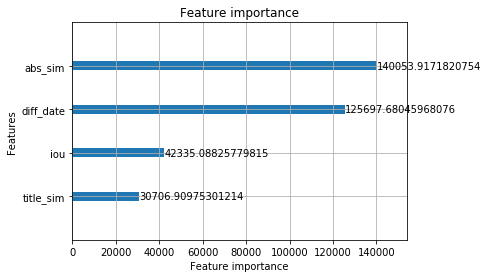

In [77]:
lgb.plot_importance(gbm,importance_type='gain')

In [78]:
preds=gbm.predict(test_X)

In [79]:
test_df['pred']= preds

In [80]:
arr=[]
for pmid, grp in test_df.groupby('pmid'):
    sind=grp['pred'].values.argsort()[::-1]
    keep1=np.sort(grp['pred'].values)[::-1]>0.5
    if (sum(np.sort(grp['pred'].values)[::-1]>0.5))>0:
        arr.append((pmid,list(grp['out_pmid'].values[sind][keep1])))
    elif (sum(np.sort(grp['pred'].values)[::-1]>0.4)>0):
        keep1=np.sort(grp['pred'].values)[::-1]>0.4
        arr.append((pmid,list(grp['out_pmid'].values[sind][keep1])))
    elif (sum(np.sort(grp['pred'].values)[::-1]>0.3)>0):
        keep1=np.sort(grp['pred'].values)[::-1]>0.3
        arr.append((pmid,list(grp['out_pmid'].values[sind][keep1])))
    elif (sum(np.sort(grp['pred'].values)[::-1]>0.2)>0):
        keep1=np.sort(grp['pred'].values)[::-1]>0.2
        arr.append((pmid,list(grp['out_pmid'].values[sind][keep1])))
    elif (sum(np.sort(grp['pred'].values)[::-1]>0.1)>0):
        keep1=np.sort(grp['pred'].values)[::-1]>0.1
        arr.append((pmid,list(grp['out_pmid'].values[sind][keep1])))
    else:
#         arr.append((pmid,[]))
#         print np.sort(grp['pred'].values)[::-1][:2]
        arr.append((pmid,list(grp['out_pmid'].values[sind][:4])))
    

In [81]:
out_df = pd.DataFrame(arr,columns=['pmid','ref_list'])#.to_csv('sub_new.csv',index=False)

In [82]:
def get_same_articles(row):

    pmid=row['pmid']
    ref_list=row['ref_list']
    if pmid!=pmid:
        return
    set_no = all_info[all_info.pmid==pmid].set.values[0]
    set_articles = all_info[all_info['set']==set_no]
    if (pmid-1) in set_articles.pmid.values:
        if (pmid-1) not in ref_list:
            ref_list.append(pmid-1)
    if (pmid-2) in set_articles.pmid.values:
        if (pmid-2) not in ref_list:
            ref_list.append(pmid-2)
    ref_list=[x for x in ref_list if x!=pmid]
    row['ref_list']=ref_list
    return row

In [83]:
out_df=out_df.apply(get_same_articles,axis=1)

In [84]:
out_df.to_csv('sub_new.csv',index=False)